In [8]:
import cvxpy as cp
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools
import casadi as ca

import gurobipy as gp
from gurobipy import GRB

from __future__ import annotations
import math
from typing import Tuple, List
from numpy.linalg import solve, norm


import numpy as np
from itertools import product
from collections import defaultdict
from typing import Callable, Dict, Tuple, List, Iterable, Any

In [9]:
def fluid_value(lam, r, mu, T, x_init, q, loglevel=1):
    """
    Solve
        max_{x,a}  Σ_{t=0}^{T-1} ( Σ_i λ_i r_i a_i(t) – γ̄ )
        s.t.       x_i(t+1) = x_i(t) + λ_i a_i(t) – μ_i x_i(t)
                   Σ_i x_i(t) ≤ q
                   x_i(0) given,  x_i(t) ≥ 0,  0 ≤ a_i(t) ≤ 1.
    Parameters
    ----------
    lam, r, mu : 1-D numpy arrays of length K
    T          : horizon (int ≥ 1)  – number of *decision* periods
    x_init     : 1-D numpy array length K – initial fluid levels
    q          : capacity (scalar)
    gamma_bar  : γ̄ (scalar)  – constant term in objective
    loglevel   : Gurobi logverbosity (0 = silent)
    Returns
    -------
    obj        : optimal objective value
    x_opt      : shape (K, T+1) array, fluid trajectories
    a_opt      : shape (K, T)   array, admission variables
    """
    K = len(lam)
    assert all(arr.size == K for arr in (r, mu, x_init))

    m = gp.Model("fluid_LP")
    m.setParam("OutputFlag", loglevel)

    #-------------  Decision variables
    x = m.addVars(K, T + 1, lb=0.0, name="x")              # x_i(t) for t=0..T
    a = m.addVars(K, T,     lb=0.0, ub=1.0, name="a")      # a_i(t) for t=0..T-1

    #-------------  Objective
    reward = gp.quicksum(lam[i] * r[i] * a[i, t]
                         for i in range(K) for t in range(T))
    m.setObjective(reward, GRB.MAXIMIZE)

    #-------------  Constraints
    # Initial condition
    for i in range(K):
        m.addConstr(x[i, 0] == float(x_init[i]), name=f"init_{i}")

    # Dynamics
    for i in range(K):
        for t in range(T):
            m.addConstr(
                x[i, t + 1] == x[i, t] + lam[i] * a[i, t] - mu[i] * x[i, t],
                name=f"dynamics_{i}_{t}"
            )

    # Capacity at every epoch (including final state t = T)
    for t in range(T + 1):
        m.addConstr(
            gp.quicksum(x[i, t] for i in range(K)) <= q,
            name=f"capacity_{t}"
        )

    #-------------  Solve
    m.optimize()

    if m.Status != GRB.OPTIMAL:
        raise RuntimeError(f"Model ended with status {m.Status}")

    #-------------  Extract solutions into NumPy arrays
    x_opt = np.array([[x[i, t].X for t in range(T + 1)] for i in range(K)])
    a_opt = np.array([[a[i, t].X for t in range(T)]     for i in range(K)])
    return m.ObjVal, a_opt, x_opt

def fluid_value_eval(T, N, lam, y0, u_opt, y_opt, drop=0.0):
    J = 0
    for t in range(int((1-drop)*T)):
        J += N**2/(1-u_opt[t]) + y_opt[t] #-b
    return J
    

################################################################################
# 1.  Helpers to build the discrete state grid  (q = 10, K = 4 here)
################################################################################
def initial_state_grid(q: int, K: int):
    """
    Yield all integer vectors x ∈ ℤ₊^K with Σ x_i ≤ q.
    For q=10, K=4 ➜ 1 001 vectors.
    """
    for x in product(range(q + 1), repeat=K):   # Cartesian grid [0..q]^K
        if sum(x) <= q:                         # capacity constraint
            yield np.array(x, dtype=int)

def build_state_space(q: int, K: int) -> List[Tuple[int, ...]]:
    """All integer x ∈ ℤ⁺^K with Σ x_i ≤ q."""
    return [x for x in product(range(q + 1), repeat=K) if sum(x) <= q]  


################################################################################
# 2.  DP core – generic Bellman backward sweep
################################################################################
State      = Tuple[int, ...]                   # you may change this alias
Action     = Any                               # could be tuple, int, np.ndarray…

def bellman_backward(
    L: int,
    states: Iterable[State],
    actions_fn: Callable[[State, int], Iterable[Action]],
    reward_fn:  Callable[[State, Action, int], float],
    trans_fn:   Callable[[State, Action, int],
                         Dict[State, float]],   # {next_state: prob}
    V_terminal: Dict[State, float],
):
    """
    Evaluate V^L_k for k = 0,…,L   (your indexing 1,…,L ↔ k = 0,…,L-1 below).
    Returns
    -------
    V : list[dict]        V[k][x]   = value starting at stage k in state x
    π : list[dict]        π[k][x]   = argmax action at (k,x)
    """
    V  = [defaultdict(float) for _ in range(L + 1)]
    π  = [{} for _ in range(L)]                 # no policy needed at stage L

    V[L].update(V_terminal)                    # base case

    # backward induction
    for k in range(L - 1, -1, -1):
        for x in states:
            best_val, best_act = -np.inf, None
            for a in actions_fn(x, k):
                imm  = reward_fn(x, a, k)
                exp  = sum(p * V[k + 1][x_next]
                           for x_next, p in trans_fn(x, a, k).items())
                val = imm + exp
                if val > best_val:
                    best_val, best_act = val, a
            V[k][x] = best_val
            π[k][x] = best_act
    return V, π


In [10]:
T = 500
N = 50
K = 3
rewards = np.array([1, 2, 3])
lam_values = np.array([.51, .72, .64])
mu_values = np.array([.15, .15, .15])
q = 5
drop_factor = 0.3

STATE_SPACE = build_state_space(q, K)


def actions_fn(x: State, k: int) -> Iterable[Action]:
    """
    Example: binary admission decision per type, BUT you can put any
    discretisation you like (e.g. {0,0.5,1}) or even continuous optimisation
    if you solve an inner LP.
    """
    # all 2^K ≤ 16 binary vectors that still respect capacity q when arrivals hit
    for a in product((0, 1), repeat=K):
        yield a

def reward_fn(x: State, a: Action, k: int) -> float:
    """Immediate reward  Σ_i λ_i r_i a_i."""
    return float(np.dot(lam_values * rewards, a))

def trans_fn(x: State, a: Action, k: int) -> Dict[State, float]:
    """
    Illustrative Bernoulli arrivals + deterministic service.
    For real work you might vectorise or pre-compute this.
    """
    probs = {}
    for arrivals in product((0, 1), repeat=K):   # 2^K possibilities
        p_arr = np.prod(np.where(arrivals, lam_values, 1 - lam_values))
        # new content that actually enters (admitted & arrival=1) …
        entrants = [ai * arr for ai, arr in zip(a, arrivals)]
        # service: each existing unit leaves with prob μ_i   (deterministic ≈ expectation)
        next_state = tuple(
            max(0, xi + ent - int(np.random.rand() < mui))  # replace with expectation if deterministic
            for xi, ent, mui in zip(x, entrants, mu_values)
        )
        probs[next_state] = probs.get(next_state, 0.0) + p_arr
    return probs


def initial_state_grid(q: int, K: int):
    """
    Yield all integer vectors x ∈ ℤ₊^K with Σ x_i ≤ q.
    For q=10, K=4 ➜ 1 001 vectors.
    """
    for x in product(range(q + 1), repeat=K):   # Cartesian grid [0..q]^K
        if sum(x) <= q:                         # capacity constraint
            yield np.array(x, dtype=int)

initial_states = np.array(list(initial_state_grid(q, K)))  # all initial states

# ---------- example ----------
      # materialise as a list
print(f"Number of states: {len(STATE_SPACE)}")      # 1001
print(STATE_SPACE[:5])    
print(initial_states[:5])                      

Number of states: 56
[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 0, 4)]
[[0 0 0]
 [0 0 1]
 [0 0 2]
 [0 0 3]
 [0 0 4]]


In [ ]:

in_state = {x: initial_states[i] for i, x in enumerate(STATE_SPACE)}  # all initial states are valid
V_terminal = {x: fluid_value(lam_values, rewards, mu_values, T, in_state[x], q, loglevel=1)[0] for x in STATE_SPACE}


print("Fluid value:", V_terminal)
#print("Steady control value:", val_steady_control)

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i9-14900HX, instruction set [SSE2|AVX|AVX2]
Thread count: 24 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 2004 rows, 3003 columns and 6006 nonzeros
Model fingerprint: 0x51004bdb
Coefficient statistics:
  Matrix range     [5e-01, 1e+00]
  Objective range  [5e-01, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+00, 5e+00]
Presolve removed 1399 rows and 1395 columns
Presolve time: 0.00s
Presolved: 605 rows, 1608 columns, 11544 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.9350000e+03   3.449458e+02   0.000000e+00      0s
     751    1.0760125e+03   0.000000e+00   0.000000e+00      0s

Solved in 751 iterations and 0.00 seconds (0.02 work units)
Optimal objective  1.076012523e+03
Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.1 bu

In [82]:
L = 10
V, policy = bellman_backward(
    L=L,
    states=STATE_SPACE,
    actions_fn=actions_fn,
    reward_fn=reward_fn,
    trans_fn=trans_fn,
    V_terminal=V_terminal,
)

# Example: value of the empty system at stage 0
x0 = (0, 0, 0)
print(f"V₀({x0}) = {V[0][x0]:.4f}")
print(f"Greedy action there: {policy[0][x0]}")

V₀((0, 0, 0)) = 1093.2097
Greedy action there: (1, 0, 1)


In [87]:
import math
from collections import defaultdict
from typing import Dict, Iterable, Any, Tuple, Callable, List

State  = Tuple[int, ...]                 # or any hashable type
Action = Any

def relative_value_iteration(
    states: Iterable[State],
    actions_fn: Callable[[State], Iterable[Action]],
    reward_fn:  Callable[[State, Action], float],
    trans_fn:   Callable[[State, Action], Dict[State, float]],
    x_ref: State,
    tol: float = 1e-8,
    max_iter: int = 20_000,
):
    """
    Average-reward *relative value iteration* (RVI).

    Returns
    -------
    h          : dict  – bias function with h[x_ref] = 0
    g          : float – average reward
    policy     : dict  – greedy action in each state
    n_iter     : int   – iterations performed
    resid_hist : list  – sup-norm residuals per iteration
    g_hist     : list  – running gain estimates
    """
    # --- initialise ---------------------------------------------------------
    states = list(states)                       # materialise iterator once
    h      = {x: 0.0 for x in states}           # bias initialised to 0
    resid_hist: List[float] = []
    g_hist:    List[float] = []

    # --- main loop ----------------------------------------------------------
    for n in range(1, max_iter + 1):
        h_new, policy = {}, {}
        for x in states:
            best_val, best_act = -math.inf, None
            for a in actions_fn(x):
                imm  = reward_fn(x, a)
                exp  = sum(p * h[xn] for xn, p in trans_fn(x, a).items())
                val  = imm + exp
                if val > best_val:
                    best_val, best_act = val, a
            h_new[x] = best_val
            policy[x] = best_act

        g = h_new[x_ref]                # gain estimate   gₙ = h̃ₙ(x_ref)
        g_hist.append(g)

        # centre the bias so that h(x_ref)=0
        for x in states:
            h_new[x] -= g

        # sup-norm residual ‖h_{n+1}-h_n‖∞
        res = max(abs(h_new[x] - h[x]) for x in states)
        resid_hist.append(res)

        if res < tol:
            return h_new, g, policy, n, resid_hist, g_hist

        h = h_new                       # iterate

    # did not converge within max_iter
    return h, g, policy, max_iter, resid_hist, g_hist

In [11]:
##############################################################################
# 0.  Imports
##############################################################################
import math, itertools, functools, numpy as np
from typing import Tuple, Dict, Iterable, Any, Callable, List
from collections import defaultdict
import math, itertools, functools, numpy as np
from typing import Tuple, Dict, Iterable, Any, Callable, List
from collections import defaultdict
from math import comb

##############################################################################
# 1.  State space   (K = 3, q = 5)
##############################################################################
def build_state_space(q: int, K: int):
    return [x for x in itertools.product(range(q + 1), repeat=K) if sum(x) <= q]

K, q = 3, 5
STATE_SPACE = build_state_space(q, K)          #  56 states
x_ref       = (0, 0, 0)                        #  reference state is valid

##############################################################################
# 2.  Model parameters (dimension 3!)
##############################################################################
lam = np.array([.51, .72, .64])
r   = np.array([1, 2, 3])
μ   = np.array([.15, .15, .15])


##############################################################################
# 3.  Helpers
##############################################################################
def actions_fn(x) -> Iterable[Tuple[int, ...]]:
    """
    All binary admission vectors a ∈ {0,1}^K that keep the *worst-case*
    load ≤ q, i.e.  sum(x) + sum(a) ≤ q.
    """
    slack = q - sum(x)
    for a in itertools.product((0, 1), repeat=K):
        if sum(a) <= slack:
            yield a

def reward_fn(x, a):
    return float(np.dot(lam * r, a))           # immediate reward

@functools.lru_cache(maxsize=None)
def trans_fn(x: Tuple[int, ...], a: Tuple[int, ...]) -> Dict[Tuple[int, ...], float]:
    """
    Exact one-step transition:
      • each type-i arrival happens with prob λ_i * a_i (0 if we reject),
        at most 1 arrival of each type per step;
      • each of the x_i in service departs independently with prob μ_i.
    Returns a dict {next_state: probability}.
    """
    probs: Dict[Tuple[int, ...], float] = {}

    # --- enumerate arrivals (2^K possibilities) ----------------------------
    for arrivals in itertools.product((0, 1), repeat=K):
        p_arr = np.prod(np.where(arrivals, lam, 1 - lam) ** a *
                        (1 - lam) ** (1 - np.array(a)))   # prob given a
        entrants = [ai * arr for ai, arr in zip(a, arrivals)]
        base = [xi + ent for xi, ent in zip(x, entrants)]  # before departures

        # --- enumerate departures (binomial for each type) -----------------
        def binom_pmf(n, k, p):
            return comb(n, k) * (p ** k) * ((1 - p) ** (n - k))

        for dep0 in range(base[0] + 1):
            p0 = binom_pmf(base[0], dep0, μ[0])
            for dep1 in range(base[1] + 1):
                p1 = binom_pmf(base[1], dep1, μ[1])
                for dep2 in range(base[2] + 1):
                    p2 = binom_pmf(base[2], dep2, μ[2])

                    next_state = (
                        base[0] - dep0,
                        base[1] - dep1,
                        base[2] - dep2,
                    )
                    p = p_arr * p0 * p1 * p2
                    probs[next_state] = probs.get(next_state, 0.0) + p
    return probs

##############################################################################
# 4.  Relative-value iteration
##############################################################################
def relative_value_iteration(
    states: Iterable[Tuple[int, ...]],
    actions_fn: Callable[[Tuple[int, ...]], Iterable[Any]],
    reward_fn:  Callable[[Tuple[int, ...], Any], float],
    trans_fn:   Callable[[Tuple[int, ...], Any], Dict[Tuple[int, ...], float]],
    x_ref: Tuple[int, ...],
    tol: float = 1e-8,
    max_iter: int = 20_000,
    initial_h: Dict[Tuple[int, ...], float] = None,
):
    states = list(states)
    h = {x: initial_h[x] - initial_h[x_ref] for x in states} if initial_h else {x: 0.0 for x in states}
    resid_hist, g_hist = [], []

    for n in range(1, max_iter + 1):
        h_new, policy = {}, {}
        for x in states:
            best_val, best_act = -math.inf, None
            for a in actions_fn(x):
                imm = reward_fn(x, a)
                exp = sum(p * h[xn] for xn, p in trans_fn(x, a).items())
                val = imm + exp
                if val > best_val:
                    best_val, best_act = val, a
            h_new[x] = best_val
            policy[x] = best_act

        g = h_new[x_ref]           # gain estimate
        g_hist.append(g)

        for x in states:           # centre so h(x_ref)=0
            h_new[x] -= g

        res = max(abs(h_new[x] - h[x]) for x in states)
        resid_hist.append(res)
        if res < tol:
            return h_new, g, policy, n, resid_hist, g_hist
        h = h_new

    return h, g, policy, max_iter, resid_hist, g_hist




In [12]:
##############################################################################
# 5.  Run
##############################################################################
h, g, policy, n_iter, resid, g_path = relative_value_iteration(
    states     = STATE_SPACE,
    actions_fn = actions_fn,
    reward_fn  = reward_fn,
    trans_fn   = trans_fn,
    x_ref      = x_ref,  # initial bias
)

print(f"Converged in {n_iter} iterations, g = {g:.6f}, residual = {resid[-1]:.2e}")
print(f"Bias h({x_ref}) = {h[x_ref]:.1f}")
print(f"Greedy action at {x_ref}: {policy[x_ref]}")

Converged in 29 iterations, g = 2.933830, residual = 5.37e-09
Bias h((0, 0, 0)) = 0.0
Greedy action at (0, 0, 0): (1, 1, 1)


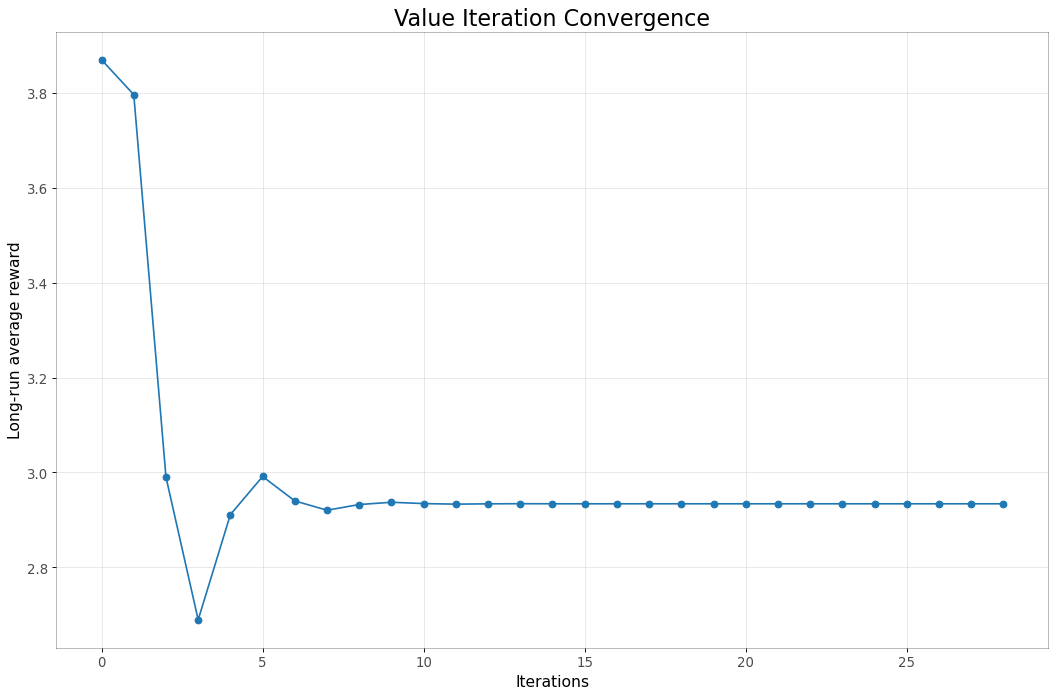

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,10), dpi= 80)
plt.plot(g_path, marker='o')
plt.xticks(rotation=0, fontsize=12, horizontalalignment='center', alpha=.7)
plt.yticks(fontsize=12, alpha=.7)
plt.title('Value Iteration Convergence', fontsize=20)
plt.grid(axis='both', alpha=.3)
plt.xlabel('Iterations', fontsize = 14)
plt.ylabel('Long-run average reward', fontsize = 14)
plt.gca().spines["top"].set_alpha(0.3)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.3)    
plt.gca().spines["left"].set_alpha(0.3)
plt.show()
plt.close()

In [105]:
##############################################################################
# Fast lookup:   state tuple  →  row/col index 0,…,S-1
##############################################################################
STATE2IDX = {x: i for i, x in enumerate(STATE_SPACE)}
IDX2STATE = STATE_SPACE                      # for readability
S         = len(STATE_SPACE)


def truncated_rvi(N_sweeps: int, **rvi_kwargs):
    """
    Run at most N_sweeps relative-value-iteration sweeps, stopping early
    only if the residual falls below tol (if you pass one).
    Returns  h, g, π  at the last sweep (no convergence guarantee).
    """
    rvi_kwargs = dict(rvi_kwargs)            # make a local copy we can tweak
    rvi_kwargs.setdefault("max_iter", N_sweeps)
    return relative_value_iteration(**rvi_kwargs)


import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve

def evaluate_policy(
    policy: Dict[Tuple[int, ...], Tuple[int, ...]],
    states: List[Tuple[int, ...]],
    reward_fn: Callable[[Tuple[int, ...], Tuple[int, ...]], float],
    trans_fn : Callable[[Tuple[int, ...], Tuple[int, ...]], Dict[Tuple[int, ...], float]],
    x_ref: Tuple[int, ...],
):
    S = len(states)
    rows, cols, data = [], [], []
    b                = np.zeros(S + 1)        # last entry → reference eq.

    for i, x in enumerate(states):
        a        = policy[x]
        P_row    = trans_fn(x, a)             # dict {x': prob}
        rows.append(i); cols.append(i); data.append(1.0)       # +h(x)
        g_col = S                             # column index for g
        rows.append(i); cols.append(g_col); data.append(1.0)   # +g

        for xn, p in P_row.items():           # -P(x,x') h(x')
            j = STATE2IDX[xn]
            rows.append(i); cols.append(j); data.append(-p)

        b[i] = reward_fn(x, a)                # RHS = r_pi(x)

    # anchor equation  h(x_ref) = 0
    rows.append(S); cols.append(STATE2IDX[x_ref]); data.append(1.0)
    b[S] = 0.0

    A = sparse.coo_matrix((data, (rows, cols)), shape=(S + 1, S + 1)).tocsr()
    sol = spsolve(A, b)                       # [h_vec | g]  (g in last entry)
    h_vec, g = sol[:-1], sol[-1]
    h = {x: h_vec[i] for i, x in enumerate(states)}
    return g, h


In [108]:
# --- 1) run 10 sweeps of RVI ---------------------------------------------
h10, g10, pi10, _, _, _ = truncated_rvi(
    1,
    states     = STATE_SPACE,
    actions_fn = actions_fn,
    reward_fn  = reward_fn,
    trans_fn   = trans_fn,
    x_ref      = x_ref,
    tol        = 0.0,
    initial_h  = V_terminal,  # initial bias
)

# --- 2) evaluate that fixed policy ----------------------------------------
g_pi, h_pi = evaluate_policy(
    policy    = pi10,
    states    = STATE_SPACE,
    reward_fn = reward_fn,
    trans_fn  = trans_fn,
    x_ref     = x_ref,
)

print(f"10-sweep policy:   gain estimate from VI = {g10:.6f}")
print(f"Exact gain under π = {g_pi:.6f}")
print("Bias at a few states:")
for st in STATE_SPACE[:5]:
    print(f"  h({st}) = {h_pi[st]:8.4f}")


10-sweep policy:   gain estimate from VI = 2.360276
Exact gain under π = 2.851726
Bias at a few states:
  h((0, 0, 0)) =   0.0000
  h((0, 0, 1)) =  -0.7097
  h((0, 0, 2)) =  -1.3118
  h((0, 0, 3)) =  -1.6673
  h((0, 0, 4)) =  -2.3712


In [110]:
l_window = np.arange(1,10)
average_rewards = np.zeros((l_window.shape[0]))

for i, l in enumerate(l_window):
    h10, g10, pi10, _, _, _ = truncated_rvi(
        l,
        states     = STATE_SPACE,
        actions_fn = actions_fn,
        reward_fn  = reward_fn,
        trans_fn   = trans_fn,
        x_ref      = x_ref,
        tol        = 0.0,
        initial_h  = V_terminal,  # initial bias
    )

    # --- 2) evaluate that fixed policy ----------------------------------------
    average_rewards[i], h_pi = evaluate_policy(
        policy    = pi10,
        states    = STATE_SPACE,
        reward_fn = reward_fn,
        trans_fn  = trans_fn,
        x_ref     = x_ref,
    )


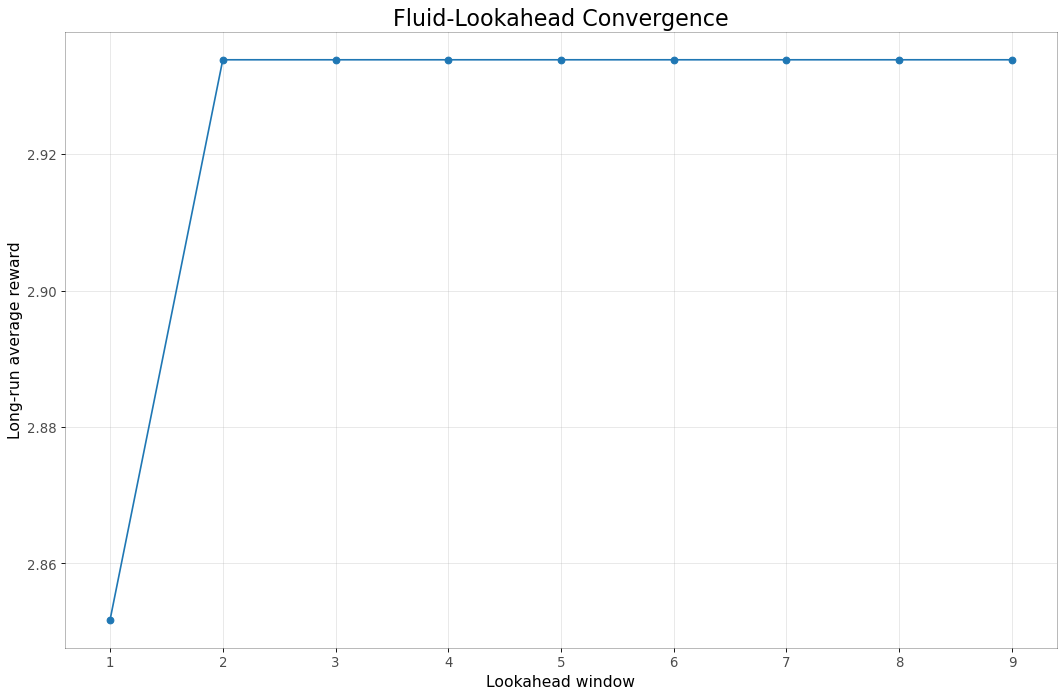

In [116]:
plt.figure(figsize=(16,10), dpi= 80)
plt.plot(l_window, average_rewards, marker ='o')
plt.xticks(rotation=0, fontsize=12, horizontalalignment='center', alpha=.7)
plt.yticks(fontsize=12, alpha=.7)
plt.title('Fluid-Lookahead Convergence', fontsize=20)
plt.grid(axis='both', alpha=.3)
plt.xlabel('Lookahead window', fontsize = 14)
plt.ylabel('Long-run average reward', fontsize = 14)
plt.gca().spines["top"].set_alpha(0.3)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.3)    
plt.gca().spines["left"].set_alpha(0.3)
plt.show()
plt.close()